In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from collections import defaultdict
import json
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../data/race_data/2019.csv')

In [3]:
new_times_s = []
for index, time in df['Session Time'].iteritems():
    if time.count(':') == 1:
        new_times_s.append(datetime.strptime(time, '%M:%S.%f'))
    else:
        new_times_s.append(datetime.strptime(time, '%H:%M:%S.%f'))
df['Session Time'] = new_times_s

In [4]:
df.to_csv('../../data/2019/2019_mod.csv', index=False, date_format='%Y-%m-%d %H:%M:%S.%f')

In [5]:
MAXTIME = df['Session Time'].max()
start_date = datetime(1900, 1, 1)
MAXTIME = (MAXTIME - start_date).total_seconds()
MAXTIME

6091.703

In [6]:
pit_times = {}
for car in list(pd.unique(df.Car)):
    df_car = df.loc[(df['Car'] == car) & (df['Location'] == 'Pit')]
    pt = list(pd.unique(df_car['Session Time']))
    d_zero = np.datetime64('1900-01-01T00:00:00')
    pt = [(d - d_zero) / np.timedelta64(1, 's') for d in pt]
    pt = [0] + pt
    pit_times[car] = pt

In [7]:
flagtimes = [60.0, 1800.0, 2460.0, 3540.0, 4200.0]
cars = []

def getLastPit(car, time):
    lp = max([t for t in pit_times[car] if t <= time])
    return (time - lp) / 60

with open('../../data/2019/19_stopped_car_pit.csv', 'w') as f:
    f.write('Car,Flag Time,Last Pit\n')
    
    for t in zip(cars, flagtimes):
        f.write("%s,%s,%s\n"%(t[0], t[1], getLastPit(t[0], t[1])))

In [8]:
def get_risk_score(x):
    MEAN1 = 0
    STD1 = 21.751478190190515
    return norm.pdf(x, MEAN1, STD1)*10

In [9]:
intervals = pd.read_csv('../../data/2019/19_start_end.csv')
intervals = intervals.to_records(index=False)
intervals = [t for t in intervals if t[0] in flagtimes]
intervals

[(60., 720.), (1800., 2400.), (2460., 2760.), (3540., 4140.), (4200., 4680.)]

In [10]:
risk_score = {}
sus_score = {}
intervals_c = np.copy(intervals)
for t in range(0, int(MAXTIME), 60):
    agg_risk = 0
    agg_sus = 0
    for car in pit_times:
        if len(intervals_c) > 0 and intervals_c[0][0] < t < intervals_c[0][1]:
            pass
        elif len(intervals_c) > 0 and t > intervals_c[0][1]:
            intervals_c = intervals_c[1:]
        else:
            agg_risk += get_risk_score(getLastPit(car, t))
        
        previous = [time for time in pit_times[car] if time <= t]
        pt = 0
        sus = 0
        for p in previous[1:]:
            if p - pt < 600:
#                 print(previous)
                sus += 100
            elif p - pt < 900:
                sus += 80
            elif p - pt < 1500:
                sus += 30
            else:
                sus -= .25
            pt = p
        agg_sus += sus
        
    risk_score[t] = agg_risk
    sus_score[t] = agg_sus

In [11]:
sus_deriv = {}
intervals_c = np.copy(intervals)
for t in range(60, int(MAXTIME), 60):
    sus_deriv[t] = (sus_score[t] - sus_score[t-60]) / 60
    if len(intervals_c) > 0:
        if intervals_c[0][0] < t < intervals_c[0][1]:
            sus_deriv[t] = 0
        elif t > intervals_c[0][1]:
            intervals_c = intervals_c[1:]

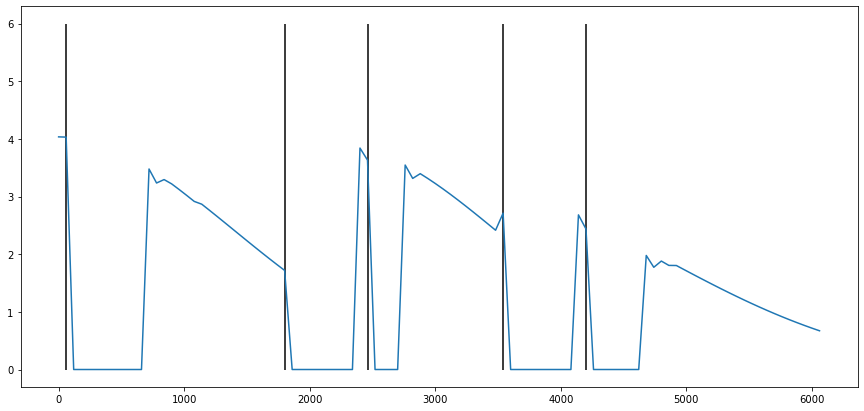

In [12]:
plt.figure(figsize=(15,7))
plt.plot(list(risk_score.keys()), list(risk_score.values()))
plt.vlines(flagtimes, 0, 6)
plt.show()

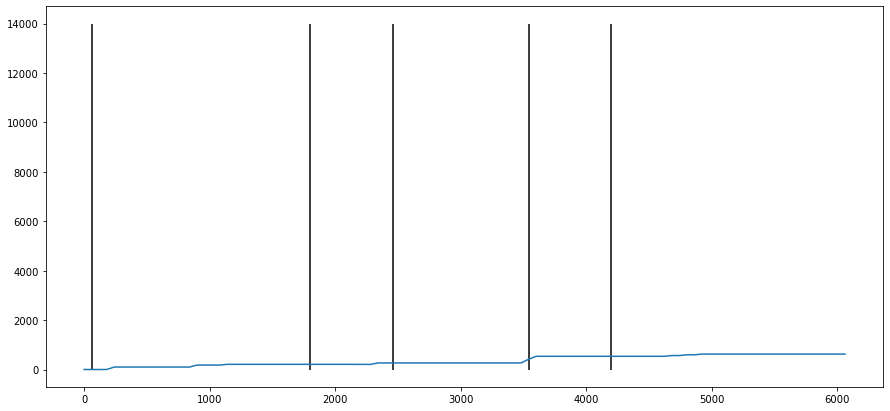

In [13]:
plt.figure(figsize=(15,7))
plt.plot(list(sus_score.keys()), list(sus_score.values()))
plt.vlines(flagtimes, 0, 14000)
plt.show()

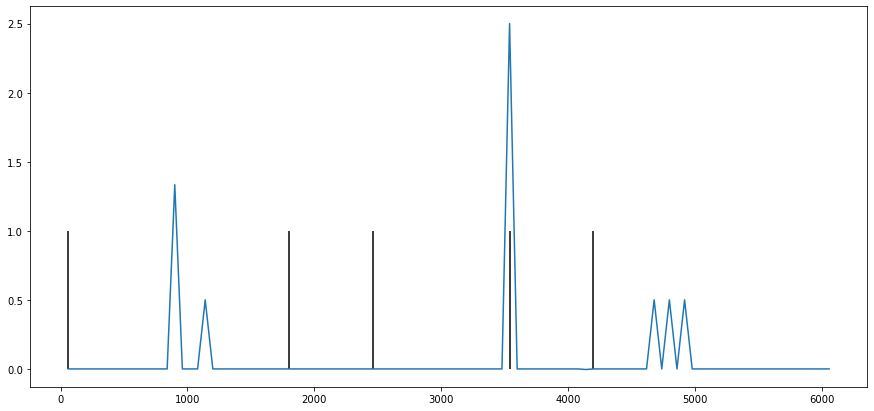

In [14]:

plt.figure(figsize=(15,7))
plt.plot(list(sus_deriv.keys()), list(sus_deriv.values()))
plt.vlines(flagtimes, 0, 1)
plt.show()

In [15]:
with open('../../data/2019/19_risk_score.csv', 'w') as f:
    f.write('Time,Risk Score\n')
    for k,v in risk_score.items():
        f.write('%s,%s\n'%(k,v))

In [16]:
with open('../../data/2019/19_sus_deriv.csv', 'w') as f:
    f.write('Time,Sus Deriv\n')
    for k,v in sus_deriv.items():
        f.write('%s,%s\n'%(k,v))

In [17]:
cars = [38, 19, 74, 19, 47]
times = [27940, 36360, 65440, 68460, 70540]
stopped_pit = [(t[0], t[1], getLastPit(t[0], t[1])) for t in zip(cars, times)]

with open('../../data/2020/20_stopped_car_pit.csv', 'w') as f:
    f.write('Car,Flag Time,Last Pit\n')
    for s in stopped_pit:
        f.write("%s,%s,%s\n"%(s[0], s[1], s[2]))

KeyError: 38

In [ ]:
# stopped cars: [47, 19, 74, 19, 38]

In [11]:
# last_pit = {}
# for t in range(20, MAXTIME, 20):
#     all_times = []
#     for car in pit_times.keys():
#         lp = max(filter(lambda pt: pt < t, pit_times[car]))
#         all_times.append(t - lp)
#     last_pit[t] = np.average(all_times) / 60

In [14]:
distances = {1: 1876, 2: 1751.33, 3: 1768.67, 4: 2352, 5: 1488, 6: 1475, 7: 1427, 
             8: 1428, 9: 1457, 10: 1484, 11: 1283, 12: 120, 13: 886.83}

num_drivers = defaultdict(lambda: defaultdict(list))
concentration = defaultdict(lambda: defaultdict(float))
last_pit = {}
avg_speed = {}
for t in range(20, MAXTIME, 20):
#     cars = []
#     speeds = []
#     for driver in section_mod:
#         for interval in section_mod[driver]:
#             if interval[1] <= t <= interval[2]:
#                 num_drivers[t][interval[0]].append((interval[1], interval[2]))
#                 cars.append(interval[3])
#                 speeds.append(interval[4])
#                 break
#     for section in num_drivers[t]:
#         concentration[t][section] = (len(num_drivers[t][section]) / distances[section]) * 1000
        # cars per 1000 feet
    
    all_times = []
    for car in cars:
        lp = max(filter(lambda pt: pt < t, pit_times[car]))
        all_times.append(t - lp)
    last_pit[t] = np.max(all_times) / 60
    avg_speed[t] = np.average(speeds)

In [15]:
with open('../../data/2019/19_num_drivers.json', 'w') as outfile:
    json.dump(num_drivers, outfile)
with open('../../data/2019/19_concentrations.csv', 'w') as f:
    f.write('Time,Sector,Concentration\n')
    for time in concentration.keys():
        for sector in range(1,14):
            f.write("%s,%s,%s\n"%(time, sector, concentration[time].get(sector, 0)))

In [16]:
with open('../../data/2019/19_time_since_pit.csv', 'w') as f:
    f.write('Time,Last Pit\n')
    for time, lp in last_pit.items():
        f.write("%s,%s\n"%(time, lp))

In [18]:
with open('../../data/2019/19_avg_speed.csv', 'w') as f:
    f.write('Time,Speed\n')
    for time, speed in avg_speed.items():
        f.write("%s,%s\n"%(time, speed))